In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
from urllib.request import urlretrieve as download
from glob import glob as g
from Bio.Blast import NCBIWWW, NCBIXML
from mypdb import PDB_file as mypdb
from Bio.Blast.Applications import NcbipsiblastCommandline
from time import time as t
from tqdm import tqdm


import glob
import xml.etree.ElementTree as ET
from collections import defaultdict

import re
import MDAnalysis as mda
from time import time as t

In [ ]:
#Class to handle and download the hits from a blast search



def merge_dicts(dict1, dict2):
    for k2, v2 in dict2.items():
        if k2 in dict1:
            if isinstance(dict1[k2], list):
                dict1[k2].append(v2)
            else:
                dict1[k2] = [dict1[k2], v2]
        else:
            print(f"New Key : {k2}")
            dict1[k2] = v2
    return dict1

class hit:
    def __init__(self, xml_hit):
        self.hit_num = xml_hit[0].text
        pdb_info = xml_hit[1].text.split("|")[1:]
        self.pdb_id = pdb_info[0]
        self.pdb_chain = pdb_info[1]
        self.description = xml_hit[2].text
        data = [[y.tag.replace("Hsp_", ""), y.text] for y in xml_hit[5][0]]
        self.data = dict(data)
        self.pdb = None
        self._not_exists = False

    @staticmethod
    def download2(code, pdir=None):
        base_url = "https://files.rcsb.org/download"
        pdb_url = f"{base_url}/{code}.pdb"
        f_p = os.path.join(pdir, f"{code}.pdb")
        try:
            download(pdb_url, f_p)
            return f_p  # Return the file path if succeeded
        except Exception:
            print(f"File {code} not found.")
            return None  # Return None if failed

    def _assign(self, f_p):
        self.pdb_path = f_p
        self.pdb = mypdb(f_p)
        
    def check_for_pdb(self, pdir=None):
        if pdir is None:
            pdir = "./pdbs/"
        elif pdir[-1] != "/":
            pdir += "/"
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        matches = g(pdir + f"{self.pdb_id}*")
        if matches:
            if not self.pdb:
                self._assign(matches[0])
            return True
        else:
            return False

In [ ]:
#Class to handle the blast search
class blast:
    def __init__(self, sequence, name, database, path, program="blastp", hitlen=10000):
        self.sequence = sequence
        self.program = program
        self.database = database
        self.path = path
        self.name = name
        self.hitlen = hitlen

        if program == "blastp" and (self.path and os.path.isfile(self.path)):
            self.parse_search()
        elif program == "psiblast":
            self.psiblast_search()
        else:
            self.bsearch()

    def bsearch(self):
        # Perform the initial BLASTP search
        if self.program == "blastp":
            print("Searching BLASTP...")
            t1 = t()
            self.results = NCBIWWW.qblast(self.program, self.database, self.sequence, hitlist_size=self.hitlen)
            t2 = t()
            print(f"BLASTP took {round(t2-t1,4)} seconds")
            if not self.path:
                self.path = f"{self.name}-blast.xml"
            with open(self.path, "w") as output_xml:
                output_xml.write(self.results.read())
            self.parse_search()

    def psiblast_search(self):
        # Run local PSI-BLAST using NcbipsiblastCommandline
        print(f"Running PSI-BLAST on {self.name}...")
        input_fasta = f"{self.name}.fasta"
        with open(input_fasta, "w") as f:
            f.write(f">query\n{self.sequence}\n")

        psiblast_cline = NcbipsiblastCommandline(
            query=input_fasta,
            db="/home/marmatt/ncbi-blast-2.16.0+/bin/pdbaa",
            evalue=10,
            num_iterations=3,
            out_ascii_pssm=f"{self.name}.pssm",
            out=f"{self.name}-psiblast.xml",
            outfmt=5
        )
        stdout, stderr = psiblast_cline()
        if stderr:
            print(f"PSI-BLAST ERROR: {stderr}")
        else:
            print("PSI-BLAST search completed.")
            self.parse_search(xml_file=f"{self.name}-psiblast.xml")

    def parse_search(self, xml_file=None):
        xml_file = xml_file or self.path
        if not xml_file:
            raise Exception("No XML file path provided.")
        t1 = t()
        tree = ET.parse(xml_file)
        iteration = tree.findall("./BlastOutput_iterations/Iteration/")
        self.query_length = iteration[3].text
        hits = [hit(x) for x in iteration[-2]] #returns hit objects
        self.hits = hits
        mega_dict = hits[0].data
        for x in hits[1:]:
            mega_dict = merge_dicts(mega_dict, x.data)
        mega_dict["PDB ID"] = [x.pdb_id for x in hits]
        mega_dict["Chain"] = [x.pdb_chain for x in hits]
        mega_dict["Description"] = [x.description for x in hits]
        self.df = pd.DataFrame.from_dict(mega_dict)
        print(self.df)
        t2 = t()
        print(f"Time taken to parse {t2-t1}")
    
    def download_pdbs(self, pdir=None):
        default_dir = "./PDBs"
        pdir = os.path.abspath(pdir if pdir else default_dir)
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        
        files = [os.path.splitext(f)[0] for f in os.listdir(pdir)]
        hit_bar = tqdm(self.hits, desc="Processing Hits")
        
        for x in hit_bar:
            if x.pdb_id not in files:
                hit_bar.set_description(f"Downloading {x}")
                
                try:
                    file_path = x.download2(x.pdb_id, pdir=pdir)

                    if file_path:
                        x._assign(file_path)
                    else:
                        # In case download2 does not return a valid path
                        raise Exception("Download failed")
                except Exception as e:
                    # Print a message if download fails or file path is invalid
                    print(f"Structure {x.pdb_id} was not found...")

## Actually running the blast search

In [ ]:

"""
Here we perform a blast search on:
 1.   The BRAF monomer
"""
with open("./fastas.txt") as f:
    fastas = f.readlines()

braf_fasta = fastas[1]
name = "braf"

# Directory for storing blast search results
output_dir = "./blast_search"
# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

res_path = os.path.join(output_dir, f"{name}-blast.xml")  # Path for the results file

# Check for saved results in the specified directory
if os.path.exists(res_path):
    bs = blast(braf_fasta, name, database="pdb", path=res_path)
else:
    bs = blast(braf_fasta, name, database="pdb", path=None)

bs.download_pdbs()

## Counting the number of pdb files in the directory

In [ ]:


import glob
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'PDBs'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

## Counting the number of pdb hits in the xml file and checking which ones have not been downloaded


In [ ]:


def count_pdb_files(directory):
    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Extract the base filenames (without extension) to compare with PDB IDs
    pdb_file_ids = {os.path.splitext(os.path.basename(f))[0] for f in pdb_files}

    return pdb_file_ids

def find_unique_and_duplicate_pdb_hit_ids(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Dictionary to count occurrences of each PDB hit ID
    hit_id_counts = defaultdict(int)

    # Iterate over all Hit elements in the XML
    for hit in root.findall('.//Hit'):
        # Extract the Hit_id text
        hit_id = hit.find('Hit_id').text

        # Assuming the Hit_id format is 'pdb|PDB_ID|Chain', extract the PDB_ID
        pdb_id = hit_id.split('|')[1]

        # Increment the count for this PDB_ID
        hit_id_counts[pdb_id] += 1

    # Find all PDB IDs (unique and duplicates)
    all_hit_ids = set(hit_id_counts.keys())

    return all_hit_ids

# Specify the directory and XML file
pdb_directory = 'PDBs'
xml_file = 'braf-blast.xml'

# Get the PDB file IDs from the directory
pdb_file_ids = count_pdb_files(pdb_directory)

# Get all PDB hit IDs from the XML
all_pdb_ids = find_unique_and_duplicate_pdb_hit_ids(xml_file)

# Calculate the number of total PDB hits
total_pdb_hits = len(all_pdb_ids)

# Find PDB IDs in XML that are not in the directory
missing_pdb_ids = all_pdb_ids - pdb_file_ids

print(f"There are {total_pdb_hits} total PDB hits in the file '{xml_file}'.")
print(f"There are {len(missing_pdb_ids)} PDB IDs in the XML not found in the directory '{pdb_directory}':")
print(missing_pdb_ids)


## Here we are stripping the downloaded pdb files to only contain the chain of interest


In [ ]:
import os
from glob import glob
import re
import MDAnalysis as mda
from time import time as t
!ls
def sglob(fp, absolute=True):
    fps = sorted(glob(fp))
    if absolute:
        fps = [os.path.abspath(f) for f in fps]
    return fps

def strip_to_chain(pdb_file, chain_ID):
    u = mda.Universe(pdb_file)
    print(f"Loaded trajectory from {pdb_file} with {len(u.atoms)} atoms.")

    chain = u.select_atoms(f"protein and chainID {chain_ID}")
    if len(chain) == 0:
        print(f"Chain {chain_ID} not found in {pdb_file}.")
        return None
    return chain

def post_process(fname):
    with open(fname, "r") as f_o:
        initial_lines = f_o.readlines()

    print(f"File {fname} before post_process, first few lines:")
    print("".join(initial_lines[:20]))

    final_lines = initial_lines[-2:].copy()
    no_ter = [line for line in initial_lines if line[:3] != "TER" or line in final_lines]

    if len(no_ter) != len(initial_lines):
        with open(fname, "w") as f_o:
            print(f"Rewriting {fname}, lines reduced from {len(initial_lines)} to {len(no_ter)}")
            f_o.write("".join(no_ter))

    print(f"File {fname} after post_process, first few lines:")
    with open(fname, "r") as f_r:
        print("".join(f_r.readlines()[:20]))

def parse_xml(xml_file):
    hit_id = re.compile(r"<Hit_id>(.*?)<.Hit_id>")
    with open(xml_file, "r") as f:
        text = f.read()
        results = [h.split("|")[1:] for h in hit_id.findall(text)]
        pdb_chain_dict = {}
        for r in results:
            pdb_chain_dict[r[0]+f"_{r[1]}"] = r[1]
    return pdb_chain_dict

def get_pdb_id(fp):
    fp = fp.rsplit(".", 1)[0]
    if "/" in fp:
        fp = fp.rsplit("/", 1)[1]
    return fp

def target_name(fp, target_dir, chain):
    orig_path, file_name = fp.rsplit("/", 1)
    fp = fp.replace(orig_path, target_dir)
    fp = fp.split(".")[0] + f"_{chain}.pdb"
    return fp

def find_pdb_file(PDB_chain_id, files):
    print(files)
    if "_" in PDB_chain_id:
        PDB_id = PDB_chain_id.split("_")[0]
    assert len(PDB_id) == 4
    for f in files:
        filename = os.path.basename(f).split('.')[0]
        if filename.startswith(PDB_id):
            print(f"Found file: {f} for PDB ID: {PDB_id}")
            return f

print("BEGIN")
t1 = t()
xml = "braf-blast.xml"
pdb_dir = "PDBs"
target_dir = "Results/activation_segments/unaligned"

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

xml_chain_dict = parse_xml(xml)
print(xml_chain_dict)

pdb_files = sorted(sglob("PDBs/*.pdb"))
print(pdb_files)
keys = sorted([*xml_chain_dict.keys()], key=get_pdb_id)

print(keys)
files = [find_pdb_file(k, pdb_files) for k in keys]
print(files)
chain_IDs = [xml_chain_dict[k] for k in keys]
print(len(chain_IDs))

valid_file_chain_pairs = [(f, c) for f, c in zip(files, chain_IDs) if f is not None]
print(len(valid_file_chain_pairs))
new_file_paths = [target_name(f, target_dir, c) for f, c in valid_file_chain_pairs]
print(new_file_paths)
file_paths = [f for f, c in valid_file_chain_pairs]
print(file_paths)
print(len(file_paths))

for (fp, chain_ID, tp) in zip(file_paths, chain_IDs, new_file_paths):
    if fp is not None:
        try:
            print(fp, chain_ID, tp)
            chain = strip_to_chain(fp, chain_ID)
            if chain is not None:
                with mda.Writer(tp) as w:
                    w.write(chain)
                post_process(tp)
        except Exception as e:
            print(f"An error occurred while processing {fp} with chain {chain_ID}: {e}")
        
t2 = t()
t_t = round(t2 - t1, 3) // 60
t_t = str((t_t // 60)) + ":" + str(t_t % 60)
print(f"Time taken {t_t} for sequential processing")


## Counting again how many pdb files are in the directory after stripping the chains

In [ ]:
import glob

def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/unaligned'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Extracting the full sequence from the pdb files, checking if there are any non-natural amino acids and substituting them and selecting only sequences with a maximum gap length of 4 amino acids to be reconstructed
from Bio.PDB import PDBParser, PPBuilder
from Bio.SeqUtils import seq1
from glob import glob
from tqdm import tqdm
import os

def substitute_non_natural_amino_acid(residue, aligned_atom, index):
    """Substitute non-natural amino acids with their natural counterparts."""
    substitutions = {
        'X': 'G',  # Glycine
        'B': 'N',  # Asparagine
        'Z': 'Q',  # Glutamine
        'J': 'L'   # Leucine
    }
    
    if residue == 'X':
        # Check if 'X' is surrounded by missing amino acids in aligned_atom
        if index > 0 and aligned_atom[index - 1] == '-':
            return residue
        if index < len(aligned_atom) - 1 and aligned_atom[index + 1] == '-':
            return residue

    return substitutions.get(residue, residue)

def extract_seqres_sequence(pdb_file):
    """Extract SEQRES sequences for each chain from a PDB file."""
    seq_dict = {}
    with open(pdb_file, "r") as file:
        lines = file.readlines()

    current_chain = None
    current_seq = []

    for line in lines:
        if line.startswith("SEQRES"):
            parts = line.split()
            chain_id = parts[2]
            if chain_id != current_chain:
                if current_chain is not None:
                    seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)
                current_chain = chain_id
                current_seq = []
            current_seq.extend(parts[4:])

    if current_chain is not None:
        seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)

    return seq_dict

def extract_atom_sequence(pdb_file, chain_id):
    """Extract sequence from atomic coordinates for a specific chain."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        chain = model[chain_id]
        
        ppb = PPBuilder()
        sequence = ''
        for pp in ppb.build_peptides(chain):
            sequence += pp.get_sequence()
        return sequence
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def align_and_highlight_gaps(seqres_segment, atom_segment):
    """Align SEQRES and ATOM segments and highlight gaps in ATOM."""
    aligned_seqres = ''
    aligned_atom = ''
    atom_index = 0
    max_gap_length = 0
    current_gap_length = 0

    for res_seqres in seqres_segment:
        if atom_index < len(atom_segment) and res_seqres == atom_segment[atom_index]:
            aligned_seqres += res_seqres
            aligned_atom += atom_segment[atom_index]
            atom_index += 1
            current_gap_length = 0
        else:
            aligned_seqres += res_seqres
            aligned_atom += '-'
            current_gap_length += 1
            max_gap_length = max(max_gap_length, current_gap_length)

    return aligned_seqres, aligned_atom, max_gap_length

def main():
    target_dir = "Results/activation_segments/unaligned"
    pdb_dir = "PDBs"
    fasta_output_file = "seqres_sequences.fasta"  # File to store full sequences
    text_output_file = "seqres_info.txt"
    aligned_sequences = {}
    satisfying_structures_count = 0

    pdb_files = glob(os.path.join(target_dir, "*.pdb"))

    with open(text_output_file, "w") as text_output, open(fasta_output_file, "w") as fasta_output:
        for pdb_file in tqdm(pdb_files, desc="Processing PDB files"):
            pdb_name = os.path.basename(pdb_file)
            pdb_id, chain_id_file = os.path.splitext(pdb_name)[0].split('_')
            chain_id = chain_id_file

            full_pdb_path = os.path.join(pdb_dir, pdb_id + '.pdb')
            if not os.path.isfile(full_pdb_path):
                print(f"Corresponding full PDB for {pdb_id} not found.")
                continue

            seqres_seqs = extract_seqres_sequence(full_pdb_path)
            atom_seq = extract_atom_sequence(full_pdb_path, chain_id)

            if chain_id in seqres_seqs and atom_seq:
                seqres_sequence = seqres_seqs[chain_id]
                seqres_dfg_index = find_motif_indices(seqres_sequence, 'DFG')
                seqres_ape_index = find_motif_indices(seqres_sequence, 'APE')
                atom_dfg_index = find_motif_indices(atom_seq, 'DFG')
                atom_ape_index = find_motif_indices(atom_seq, 'APE')

                # Determine the start and end indices for the segments
                if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
                    seqres_start = min(seqres_dfg_index, seqres_ape_index)
                    seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
                    atom_start = min(atom_dfg_index, atom_ape_index)
                    atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

                    seqres_segment = seqres_sequence[seqres_start:seqres_end]
                    atom_segment = atom_seq[atom_start:atom_end]

                    aligned_seqres, aligned_atom, max_gap_length = align_and_highlight_gaps(seqres_segment, atom_segment)
                    
                    # Check for differences and substitute non-natural amino acids
                    exclude_due_to_non_natural_diff = False
                    corrected_seqres = ''
                    for index, (res_seqres, res_atom) in enumerate(zip(aligned_seqres, aligned_atom)):
                        if res_seqres != res_atom:
                            corrected_residue = substitute_non_natural_amino_acid(res_seqres, aligned_atom, index)
                            corrected_seqres += corrected_residue
                            if corrected_residue != res_seqres:
                                print(f"Substituting non-natural amino acid '{res_seqres}' with '{corrected_residue}' in SEQRES for {pdb_id}_{chain_id}.")
                        else:
                            corrected_seqres += res_seqres

                    if not exclude_due_to_non_natural_diff and max_gap_length <= 4:
                        satisfying_structures_count += 1
                        info = (f"Aligned Sequences for {pdb_id}_{chain_id}: (Max gap length: {max_gap_length})\n"
                                f"SEQRES Segment: {corrected_seqres}\n"
                                f"ATOM Segment:   {aligned_atom}\n\n")
                        print(info)
                        text_output.write(info)
                        
                        aligned_sequences[f"{pdb_id}_{chain_id}_SEQRES"] = corrected_seqres
                        aligned_sequences[f"{pdb_id}_{chain_id}_ATOM"] = aligned_atom

                        # Write full SEQRES and ATOM sequences to the FASTA file
                        fasta_output.write(f">{pdb_id}_{chain_id}_SEQRES\n{seqres_sequence}\n")
                        fasta_output.write(f">{pdb_id}_{chain_id}_ATOM\n{atom_seq}\n")
                    else:
                        exclusion_msg = f"Excluding {pdb_id}_{chain_id} due to gap length: {max_gap_length} or non-natural amino acid difference.\n"
                        print(exclusion_msg)
                        text_output.write(exclusion_msg)
                else:
                    motif_msg = f"Motifs not found in {pdb_id}_{chain_id}.\n"
                    print(motif_msg)
                    text_output.write(motif_msg)
            else:
                chain_msg = f"Chain {chain_id} not found in SEQRES of {pdb_id} or no atomic sequence available.\n"
                print(chain_msg)
                text_output.write(chain_msg)
                
        count_msg = f"Total structures satisfying the condition: {satisfying_structures_count}"
        text_output.write(count_msg)
        print(count_msg)

if __name__ == '__main__':
    main()


In [ ]:
#COunting how many seqences are in the fasta file
def count_total_pdb_ids(file_path):
    total_pdb_ids = 0

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                total_pdb_ids += 1

    print(f"Total number of PDB IDs: {int(total_pdb_ids/2)}") #here we divide by 2 because we have two lines per PDB ID

# Provide the path to your seqres_sequence.fasta file
file_path = "seqres_sequences.fasta"
count_total_pdb_ids(file_path)


In [ ]:
#Code to use MODELLER to reconstruct the sequences that have a gap length of 4 or less, if there are no differences between the SEQRES and ATOM sequences, the original PDB file is copied to the target directory
# FIX was to eliminate remarks from the pdb file
import os
import shutil
from Bio.PDB import PDBParser, PPBuilder
from modeller import *
from modeller.automodel import *

def read_fasta_sequences(fasta_file):
    """Read sequences from a FASTA file into a dictionary."""
    sequences = {}
    with open(fasta_file, "r") as f:
        lines = f.readlines()
        header = None
        sequence = []
        for line in lines:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences[header] = ''.join(sequence)
                header = line[1:]
                sequence = []
            else:
                sequence.append(line)
        if header:
            sequences[header] = ''.join(sequence)
    return sequences

def extract_atom_sequence(pdb_file):
    """Extract sequence from atomic coordinates for the first chain found in the PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            return str(sequence)
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def reconstruct_with_modeller(pdb_chain_id, pdb_path, target_path, full_sequence, atom_sequence):
    print(f"Processing {pdb_chain_id}")

    # Find indices of the DFG and APE motifs
    seqres_dfg_index = find_motif_indices(full_sequence, 'DFG')
    seqres_ape_index = find_motif_indices(full_sequence, 'APE')
    atom_dfg_index = find_motif_indices(atom_sequence, 'DFG')
    atom_ape_index = find_motif_indices(atom_sequence, 'APE')

    # Determine if reconstruction is needed
    if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
        seqres_start = min(seqres_dfg_index, seqres_ape_index)
        seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
        atom_start = min(atom_dfg_index, atom_ape_index)
        atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

        seqres_segment = full_sequence[seqres_start:seqres_end]
        atom_segment = atom_sequence[atom_start:atom_end]

        # Check for differences in the segment
        if seqres_segment != atom_segment:
            print(f"Reconstructing full sequence for {pdb_chain_id} using MODELLER")

            # Setting up MODELLER
            env = environ()
            aln = alignment(env)
            
            # Read the structure to work on
            mdl = model(env, file=pdb_path)
            aln.append_model(mdl, align_codes='template', atom_files=pdb_path)

            # Append the full target sequence
            aln.append_sequence(full_sequence)
            aln[-1].code = 'target'
            
            # Perform the alignment
            aln.align2d(max_gap_length=50)

            # Create AutoModel object and build models
            a = automodel(env, alnfile=aln, knowns='template', sequence='target')
            a.starting_model = 1
            a.ending_model = 1
            
            # Build the model
            a.make()
            
            # Save the best model to the target directory
            model_path = os.path.join(target_path, f"{pdb_chain_id}_filled.pdb")
            os.rename(a.outputs[0]['name'], model_path)
            print(f"Reconstruction completed for {pdb_chain_id}. File saved at {model_path}")

            # Post-process to remove REMARK lines
            remove_remark_lines(model_path)
        else:
            # No reconstruction needed, copy original PDB
            shutil.copy(pdb_path, os.path.join(target_path, f"{pdb_chain_id}.pdb"))
            print(f"No differences found for {pdb_chain_id}. Original PDB copied to target directory.")
    else:
        print(f"Motifs not found in {pdb_chain_id}.")

def remove_remark_lines(pdb_file):
    """Remove lines starting with 'REMARK' from the PDB file."""
    with open(pdb_file, 'r') as file:
        lines = file.readlines()
    
    with open(pdb_file, 'w') as file:
        for line in lines:
            if not line.startswith("REMARK"):
                file.write(line)
    
    print(f"Removed REMARK lines from {pdb_file}")

def main():
    seqres_fasta = "seqres_sequences.fasta"
    pdb_dir = "Results/activation_segments/unaligned"
    target_dir = "Results/activation_segments/reconstructedModeller"

    # Read the sequences from the FASTA file
    seqres_sequences = read_fasta_sequences(seqres_fasta)

    for header, full_sequence in seqres_sequences.items():
        if "_SEQRES" in header:  # Only consider SEQRES entries
            pdb_chain_id = header.replace("_SEQRES", "")
            pdb_file_path = os.path.join(pdb_dir, f"{pdb_chain_id}.pdb")

            # Extract the atomic sequence
            atom_sequence = extract_atom_sequence(pdb_file_path)

            if atom_sequence is None:
                print(f"Could not extract sequence for {pdb_chain_id}. Skipping...")
                continue

            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            
            reconstruct_with_modeller(pdb_chain_id, pdb_file_path, target_dir, full_sequence, atom_sequence)

    print("Processing complete!")

if __name__ == '__main__':
    main()


In [ ]:
#Counting the number of pdb files in the directory after reconstruction
import glob
import os
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/reconstructedModeller'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Fast checking if reconstruction was successful, need to just change the pdb id and chain id
import MDAnalysis as mda
import nglview as nv
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align

# Dictionary to convert three-letter amino acid codes to one-letter codes
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLU': 'E', 'GLN': 'Q', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

def extract_sequence_and_mapping(pdb_file):
    """Extract sequence and create a mapping from sequence index to PDB residue ID."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    sequence = []
    index_to_resid = {}
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:  # Check if it's an amino acid
                    resname = residue.get_resname()
                    if resname in three_to_one:
                        sequence.append(three_to_one[resname])
                        index_to_resid[len(sequence) - 1] = residue.get_id()[1]  # Map sequence index to PDB resid
            break
        break

    return sequence, index_to_resid

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    sequence_str = ''.join(sequence)
    index = sequence_str.find(motif)
    return index if index != -1 else None

# Extract the sequence and mapping for the single chain
atom_sequence, index_to_resid = extract_sequence_and_mapping("Results/activation_segments/unaligned/7OPO_A.pdb")

# Find indices of DFG and APE motifs
dfg_index = find_motif_indices(atom_sequence, 'DFG')
ape_index = find_motif_indices(atom_sequence, 'APE')

# Ensure indices are found and select the residues between them
if dfg_index is not None and ape_index is not None:
    # Use the mapping to get the correct residue IDs
    dfg_resid = index_to_resid[dfg_index]
    ape_resid = index_to_resid[ape_index + 2]  # +2 to include the entire 'APE' motif

    u_missing = mda.Universe("Results/activation_segments/unaligned/7OPO_A.pdb")
    selected_atoms = u_missing.select_atoms(f"resid {dfg_resid}:{ape_resid}")

    print("Number of Atoms Selected:", selected_atoms.n_atoms)

    u_reconstructed = mda.Universe("Results/activation_segments/reconstructedModeller/7OPO_A_filled.pdb")
    print("Number of Atoms Reconstructed:", u_reconstructed.select_atoms(f"all").n_atoms)

    # Merge the aligned atoms for visualization
    merged = mda.Merge(selected_atoms, u_reconstructed.atoms)
    print(merged.residues)

    # Create NGLView widget
    w = nv.show_mdanalysis(merged)

    # Add a representation for each residue name with the corresponding color
    w.clear()
    w.add_cartoon(color="resname")

    

else:
    print("Motifs not found in the sequence.")

w

In [ ]:
#Helper functions and function to run MUSTANG on the reconstructed pdb files

import subprocess
import os
from glob import glob as g
import mdtraj as md
from mpi4py import MPI
from time import time as t
from tqdm import tqdm


def sg(f_p):
    return sorted(g(f_p))


def find_pdbs(directory):
    """
    Find topologies in a directory.
    Currently excludes cif files.
    """
    return sg(directory+"/*.pdb")


def fname(file):
    return file.rsplit(".", 1)[0].rsplit("/", 1)[-1]


def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path


def run_mustang(f1, f2, name=None):
    """
    Writes a MUSTANG input file which aligns
    file1 to file 2.
    If no name defaults to the second file.
    """
    if name is None:
        name = fname(f2)
    if not os.path.isdir(f"./{name}"):
        os.makedirs(f"./{name}")
    new_fp = f"./{name}/{name}"
    structs = f"{f1} {f2} "
    command = f"/home/marmatt/Downloads/MUSTANG_v3.2.4/bin/mustang-3.2.4 -i {structs} -o {new_fp} -F fasta -s ON" #here you should change the path to where you install MUSTANG
    command = command.split()
    new_fp = f"{new_fp}.pdb"
    try:
        result = subprocess.run(command, capture_output=True, text=True)
        print(f"Running command: {' '.join(command)}")
        print(f"STDOUT: {result.stdout}")
        print(f"STDERR: {result.stderr}")
        if result.returncode != 0:
            print("Error in MUSTANG execution")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None
    return new_fp


def postprocess(file_path):
    """
    file_path is the name of a pdb file.
    It deletes the first chain which is always the alignment structures
    """
    structure = md.load(file_path)
    aligned_chain_idx = [[atom.index for atom in res.atoms] for res in
                         structure.top._chains[1]._residues]
    aligned_chain_idx = sum(aligned_chain_idx, [])
    structure = structure.atom_slice(aligned_chain_idx)
    structure.save(file_path)

In [ ]:
#Perform MUSTANG alignment on the sequences that have not been reconstructed, I need to fix this bug

#from mustang import *
import subprocess
from mpi4py import MPI

# Constants (most to be made variable)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
# Define the paths explicitly
pdb_path = "Results/activation_segments/reconstructedModeller"
#pdb_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/unaligned"
target_dir = "Results/activation_segments/mustangs"
template_pdb = "6UAN_chainD.pdb"
# Ensure the target directory exists
ifnotmake(target_dir)
pdb_path = os.path.abspath(pdb_path)
target_dir = os.path.abspath(target_dir)
template_pdb = os.path.abspath(template_pdb)
print(pdb_path, target_dir, template_pdb)
os.chdir(target_dir)
os.system("pwd")
if rank == 0:
    pdbs = find_pdbs(pdb_path)
    n_files = len(pdbs)
    n_slices = (n_files // size)
    step = int(n_files / n_slices)
    if n_files % n_slices != 0:
        n_slices += 1
    slices = [slice(i*n_slices, (i+1)*n_slices) for i in range(step)]
    pdbs = [pdbs[s] for s in slices]
else:
    pdbs = None

pdbs = comm.scatter(pdbs, root=0)
print("RANK:\t", rank, "DATA SIZE:\t", len(pdbs))
t1 = t()
failures = []
for pdb in tqdm(pdbs):
    name = fname(pdb)
    new_fp = run_mustang(template_pdb, pdb, name=name)
    if new_fp:
        if os.path.isfile(new_fp):
            postprocess(new_fp)
        else:
            failures.append(pdb)
    else:
        failures.append(pdb)
t2 = t()
print("FINISHED RANK:\t", rank, "DATA SIZE:\t", len(pdbs),
      "TIME:\t", round(t2-t1, 4))
failures = comm.gather(failures, root=0)
if rank == 0:
    failures = sum(failures, [])
    with open("./failures.txt", "w") as f_o:
        f_o.write("\n".join(f for f in failures))
    t2 = t()
    print(round(t2-t1, 3))


In [ ]:
#Code to truncate the aligned structures to only activation segment and save them to pdb files
'''
import os
import mdtraj as md
from glob import glob as g

def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path

def sg(f_p):
    return sorted(g(f_p))

def find_pdbs(directory):
    """
    Find PDB files in a directory and its subdirectories.
    """
    return sg(directory + "/**/*.pdb")

def find_motif_indices(sequence, motif):
    """
    Find the starting index of a motif in a sequence.
    Returns the index of the first residue of the motif.
    """
    motif_length = len(motif)
    for i in range(len(sequence) - motif_length + 1):
        if sequence[i:i + motif_length] == motif:
            return i
    return None

def truncate_pdb(file_path, output_dir, motif_start='DFG', motif_end='APE'):
    """
    Truncate the PDB file between the specified motifs and save to output directory.
    """
    # Load the structure
    structure = md.load(file_path)
    sequence = [res.name for res in structure.topology.residues]

    # Find indices of the motifs
    start_idx = find_motif_indices(sequence, motif_start)
    end_idx = find_motif_indices(sequence, motif_end)

    if start_idx is None or end_idx is None:
        print(f"Motifs not found in {file_path}")
        return

    # Ensure the end motif is after the start motif
    if start_idx >= end_idx:
        print(f"Invalid motif order in {file_path}")
        return

    # Slice the structure
    truncated_structure = structure.atom_slice(structure.top.select(f"residue >= {start_idx} and residue <= {end_idx}"))

    # Extract PDB ID from the file name
    pdb_id = os.path.basename(file_path).split('.')[0]

    # Save the truncated PDB with the PDB ID
    output_path = os.path.join(output_dir, f"{pdb_id}_truncated.pdb")
    truncated_structure.save(output_path)
    print(f"Truncated PDB saved to {output_path}")

def process_pdbs(input_dir, output_dir):
    """
    Process all PDB files in the input directory and save truncated versions to the output directory.
    """
    ifnotmake(output_dir)
    pdb_files = find_pdbs(input_dir)

    for pdb_file in pdb_files:
        truncate_pdb(pdb_file, output_dir)

# Define paths
input_directory = "Results/activation_segments/mustangs"
output_directory = "Results/activation_segments/mustang_truncated"

# Ensure output directory exists
ifnotmake(output_directory)

# Process all PDB files
process_pdbs(input_directory, output_directory)
'''

In [ ]:
#Code to save only first and last residue in activation segment for further visualization

import biobox as bb
import glob
import numpy as np

files = "Results/activation_segments/mustang_truncated/*.pdb"

start = []
end []
for f in glob.glob(files):

    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")

    start.append(pts[0])
    end.append(pts[-1])

start = np.array(start)
end = np.array(end)

M_start = bb.Structure(pts=start)
M_end = bb.Structure(pts=end)

M_start.write_pdb("start_CA.pdb")
M_end.write_pdb("end_CA.pdb")

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import numpy as np

# Define file paths
pdb_6UAN_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/6UAN_chainD.pdb"
pdb_3H4J_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/3H4J_A_filled/3H4J_A_filled.pdb"
output_path_mdanalysis = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs_figure/aligned3H4J_A_mdanalysis.pdb"

# Load the structures using MDAnalysis
u_6UAN = mda.Universe(pdb_6UAN_path)
u_3H4J = mda.Universe(pdb_3H4J_path)

# Define the atom selections for D and E residues
selection_6UAN_D = u_6UAN.select_atoms("resid 594 and (name CA or name CB or name N or name O)")
selection_3H4J_D = u_3H4J.select_atoms("resid 151 and (name CA or name CB or name N or name O)")

# selection_6UAN_E = u_6UAN.select_atoms("resid 623 and (name CA or name CB or name N or name O)")
# selection_3H4J_E = u_3H4J.select_atoms("resid 177 and (name CA or name CB or name N or name O)")

# Function to print details of atom selections
def print_selection_details(selection, label):
    print(f"Selection details for {label}:")
    for residue in selection.residues:
        print(f"Residue: {residue.resname} {residue.resid}, Number of atoms: {len(residue.atoms)}")
    print(f"Total number of atoms in {label}: {selection.n_atoms}")

# Print selection details
print_selection_details(selection_6UAN_D, "6UAN_D")
print_selection_details(selection_3H4J_D, "3H4J_D")
# print_selection_details(selection_6UAN_E, "6UAN_E")
# print_selection_details(selection_3H4J_E, "3H4J_E")

# Calculate RMSD for D residues before alignment
rmsd_D_before = rms.rmsd(selection_3H4J_D.positions, selection_6UAN_D.positions)
print(f"RMSD for D residues before alignment (MDAnalysis): {rmsd_D_before}")

# Calculate RMSD for E residues before alignment
rmsd_E_before = rms.rmsd(selection_3H4J_E.positions, selection_6UAN_E.positions)
print(f"RMSD for E residues before alignment (MDAnalysis): {rmsd_E_before}")

# Verify alignment selections
alignment_selection_6UAN = u_6UAN.select_atoms("resid 594 and (name CA or name CB or name N or name O)")
alignment_selection_3H4J = u_3H4J.select_atoms("resid 151 and (name CA or name CB or name N or name O)")

print_selection_details(alignment_selection_6UAN, "Alignment 6UAN")
print_selection_details(alignment_selection_3H4J, "Alignment 3H4J")

# Align using rms_fit_trj with explicit selections
# aligner = align.alignto(u_3H4J, u_6UAN, select="resid 151 and (name CA or name CB or name N or name O)", 
#                         ref_select="resid 594 and (name CA or name CB or name N or name O)")
aligner = align.alignto(selection_6UAN_D, selection_3H4J)
# Calculate RMSD for D residues after alignment
rmsd_D_after = rms.rmsd(selection_3H4J_D.positions, selection_6UAN_D.positions)
print(f"RMSD for D residues after alignment (MDAnalysis): {rmsd_D_after}")

# Save the aligned structure to a new file
with mda.Writer(output_path_mdanalysis, n_atoms=u_3H4J.atoms.n_atoms) as W:
    W.write(u_3H4J)
print(f"Aligned structure saved to {output_path_mdanalysis}")


In [ ]:
import mdtraj as md
import numpy as np

# Define file paths
pdb_6UAN_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/6UAN_chainD.pdb"
pdb_3H4J_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/3H4J_A_filled/3H4J_A_filled.pdb"
output_path_mdtraj = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs_figure/aligned3H4J_A_mdtraj.pdb"

# Load the structures using MDTraj
traj_6UAN = md.load(pdb_6UAN_path)
traj_3H4J = md.load(pdb_3H4J_path)

# Define the atom selections for D and E residues
# selection_6UAN_D = traj_6UAN.topology.select("resid 145 and name CA")
# selection_3H4J_D = traj_3H4J.topology.select("resid 150 and name CA")

# selection_6UAN_E = traj_6UAN.topology.select("resid 174 and name CA")
# selection_3H4J_E = traj_3H4J.topology.select("resid 176 and name CA")
# Expanded selection to include backbone atoms for better alignment
selection_6UAN_D = traj_6UAN.topology.select("resid 145 and (name CA or name CB or name N or name O)")
selection_3H4J_D = traj_3H4J.topology.select("resid 150 and (name CA or name CB or name N or name O)")

selection_6UAN_E = traj_6UAN.topology.select("resid 174 and (name CA or name CB or name N or name O)")
selection_3H4J_E = traj_3H4J.topology.select("resid 176 and (name CA or name CB or name N or name O)")


# Function to print atom coordinates and differences
def print_atom_coordinates_and_diff(traj1, traj2, selection1, selection2, label):
    print(f"Coordinates and differences for selection {label}:")
    for atom_index1, atom_index2 in zip(selection1, selection2):
        atom1 = traj1.topology.atom(atom_index1)
        atom2 = traj2.topology.atom(atom_index2)
        coord1 = traj1.xyz[0, atom_index1]
        coord2 = traj2.xyz[0, atom_index2]
        diff = coord2 - coord1
        print(f"Residue: {atom1.residue}, Atom: {atom1.name}, Coord1: {coord1}, Coord2: {coord2}, Diff: {diff}")

# Print coordinates and differences
print_atom_coordinates_and_diff(traj_6UAN, traj_3H4J, selection_6UAN_D, selection_3H4J_D, "D")
print_atom_coordinates_and_diff(traj_6UAN, traj_3H4J, selection_6UAN_E, selection_3H4J_E, "E")

# Calculate RMSD for D residues before alignment
rmsd_D_before = md.rmsd(traj_3H4J, traj_6UAN, atom_indices=selection_3H4J_D, ref_atom_indices=selection_6UAN_D)
print(f"RMSD for D residues before alignment (MDTraj): {rmsd_D_before[0]}")

# Calculate RMSD for E residues before alignment
rmsd_E_before = md.rmsd(traj_3H4J, traj_6UAN, atom_indices=selection_3H4J_E, ref_atom_indices=selection_6UAN_E)
print(f"RMSD for E residues before alignment (MDTraj): {rmsd_E_before[0]}")

# Align the structures based on D residues
traj_3H4J_aligned = traj_3H4J.superpose(traj_6UAN, atom_indices=selection_3H4J_D, ref_atom_indices=selection_6UAN_D)

# Calculate RMSD after alignment
rmsd_D_after = md.rmsd(traj_3H4J_aligned, traj_6UAN, atom_indices=selection_3H4J_D, ref_atom_indices=selection_6UAN_D)
print(f"RMSD for D residues after alignment (MDTraj): {rmsd_D_after[0]}")

rmsd_E_after = md.rmsd(traj_3H4J_aligned, traj_6UAN, atom_indices=selection_3H4J_E, ref_atom_indices=selection_6UAN_E)
print(f"RMSD for E residues after alignment (MDTraj): {rmsd_E_after[0]}")

# Save the aligned structure to a new file
traj_3H4J_aligned.save(output_path_mdtraj)
print(f"Aligned structure saved to {output_path_mdtraj}")


In [ ]:
import os
import pymol
from pymol import cmd

# Initialize PyMOL
print("Initializing PyMOL...")
pymol.finish_launching(['pymol', '-qc'])

# Define file paths
pdb_6UAN_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/6UAN_chainD.pdb"
pdb_3H4J_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/3H4J_A_filled/3H4J_A_filled.pdb"
output_path = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs_figure/aligned3H4J_A.pdb"

# Ensure the output directory exists
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Load the structures
cmd.load(pdb_6UAN_path, "6UAN_chainD")
cmd.load(pdb_3H4J_path, "3H4J_A")

# Function to print details of a selection
def print_selection_details(selection_name):
    print(f"Details for selection: {selection_name}")
    cmd.iterate(selection_name, "print(resi, resn, name)")
    count = cmd.count_atoms(selection_name)
    print(f"Number of atoms in {selection_name}: {count}")

# Select the D residue from both structures
cmd.select("6UAN_D", "6UAN_chainD and resi 594 and name CA+CB")
cmd.select("3H4J_D", "3H4J_A and resi 151 and name CA+CB")
print_selection_details("6UAN_D")
print_selection_details("3H4J_D")


# Select the E residue from both structures
cmd.select("6UAN_E", "6UAN_chainD and resi 623 and name CA+CB")
cmd.select("3H4J_E", "3H4J_A and resi 177 and name CA+CB")
print_selection_details("6UAN_E")
print_selection_details("3H4J_E")

# Alter identifiers to ensure they match
# cmd.alter("6UAN_D", "chain=''")
# cmd.alter("3H4J_D", "chain=''")
# cmd.alter("6UAN_E", "chain=''")
# cmd.alter("3H4J_E", "chain=''")


# Calculate RMSD for D residues before alignment
if cmd.count_atoms("6UAN_D") > 0 and cmd.count_atoms("3H4J_D") > 0:
    rmsd_D_before = cmd.rms_cur("6UAN_D", "3H4J_D", matchmaker=-1)
    print(f"RMSD for D residues before alignment: {rmsd_D_before}")

# Calculate RMSD for E residues before alignment
if cmd.count_atoms("6UAN_E") > 0 and cmd.count_atoms("3H4J_E") > 0:
    rmsd_E_before = cmd.rms_cur("6UAN_E", "3H4J_E", matchmaker=-1)
    print(f"RMSD for E residues before alignment: {rmsd_E_before}")

# Align the D residues
cmd.fit("6UAN_D", "3H4J_D", matchmaker=0)

# Align the E residues
cmd.fit("6UAN_E", "3H4J_E", matchmaker=0)

# Calculate RMSD after alignment
rmsd_D_after = cmd.rms_cur("6UAN_D", "3H4J_D")
print(f"RMSD for D residues after alignment: {rmsd_D_after}")

rmsd_E_after = cmd.rms_cur("6UAN_E", "3H4J_E")
print(f"RMSD for E residues after alignment: {rmsd_E_after}")

# Save the aligned structure
cmd.save(output_path, "3H4J_A")

# Clean up PyMOL session
cmd.quit()

#ISSUE 2: NO EFFECT ON STRUCTURE


In [ ]:
#Counting the number of directories representing the number of pdb files that have been aligned
import os
def count_directories(directory):
    # List all entries in the given directory
    entries = os.listdir(directory)

    # Use os.path.join to get the full path and os.path.isdir to check if it's a directory
    directories = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]

    # Return the count of directories
    return len(directories)

# Specify the directory
directory_path = 'Results/activation_segments/mustangs'

# Get the count of directories
directory_count = count_directories(directory_path)

print(f"There are {directory_count} directories in the directory '{directory_path}'.")


In [ ]:
#Counting the number of files representing the number of pdb files that did not need reconstruction
import os
from glob import glob as g

def count_non_filled_pdbs(directory):
    # Find all PDB files in the directory
    pdb_files = g(os.path.join(directory, "*.pdb"))

    # Filter out files with '_filled' in their names
    non_filled_pdbs = [pdb for pdb in pdb_files if "_filled" not in os.path.basename(pdb)]

    # Return the count of non '_filled' PDB files
    return len(non_filled_pdbs)

# Specify the directory
pdb_directory_path = 'Results/activation_segments/reconstructedModeller'

# Get the count of non '_filled' PDB files
non_filled_pdb_count = count_non_filled_pdbs(pdb_directory_path)

print(f"There are {non_filled_pdb_count} PDB files without '_filled' in the directory '{pdb_directory_path}'.")


In [1]:
import re
import os
import h5py
import numpy as np
import mdtraj as md
import pickle as p
from tqdm import tqdm
from glob import glob
from pprint import pprint as pp
alignment_dir = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs"

class alignment:
    """
    Class to hold alignments.
    Currently only supports braf_monomers!
    """
    def __init__(self,name,seq1,seq2):
        self.name = name
        self.seq1 = seq1
        self.seq2 = seq2
        self.aligned = self.find_aligned()

    def find_pdb(self):
        pdb_files = []
        for root, dirs, files in os.walk(alignment_dir):
            pdb_files += [os.path.join(root, file) for file in files if file.endswith('.pdb')]
        
        pdb = [f for f in pdb_files if self.name in f]
        print(pdb)
        if len(pdb) == 1:
            return pdb[0]
        

    def find_aligned(self):
        aligned = []
        for char1, char2 in zip(self.seq1,self.seq2):
            if char1 != "-":
                aligned.append((char1,char2))
        return aligned

    def aligned_res(self):
        seq1, seq2 = self.seq1, self.seq2
        aligned = [[*item] for item in self.aligned]
        seq_length = len(aligned)
        pdb2_top = self.load_pdb()
        full_seq2 = "".join(char for char in seq2 if char != "-")
        residues = pdb2_top.top._residues
        n_res = len(residues)
        res_counter = 0
        for i in range(seq_length):
            if res_counter >= n_res:
                break
            if aligned[i][1] != "-":
                aligned[i][1] = residues[res_counter]
                res_counter += 1
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                idxs = []
                for atom in res._atoms:
                    idxs.append(atom.index)
                res_xyz = xyz[idxs]
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_ca_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                for atom in res._atoms:
                    if atom.name == "CA":
                        idxs = atom.index
                        break
                try:
                    res_xyz = xyz[idxs]
                except Exception as e:
                    print(e)
                    print("ERROR FOR:")
                    print(self.name)
                    return None
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def load_pdb(self):
        return md.load(self.pdb_file)

    def __getitem__(self,idx):
        return (self.seq1[idx],self.seq2[idx])

    def __repr__(self):
        return self.name

    def find_match_id(self):
        seq1, seq2 = self.seq1, self.seq2
        full_seq2 = "".join(char for char in seq2 if char != "-")
        pp(full_seq2)
        aligned = self.aligned
        actv_low = 155
        actv_hgh = 181
        match_residues = aligned[actv_low:actv_hgh] # These are what we need
        seq2_Seq = [a[1] for a in match_residues if a[1] != "-"]
        begin_idx = 0

In [2]:
def afasta_parse(file):
    """
    Parse mustang afasta format output file.
    Returns two lists of equal length
    """
    with open(file,"r") as f:
        lines = f.readlines()
    names = [l.split(".")[0][1:] for l in lines if l[0] == ">"]
    for i in range(1,len(lines)):
        if lines[i].isspace():
            lines[i] = "BREAK"
            break
        elif lines[i][0] == ">":
            lines[i] = "BREAK" + lines[i]
            break
    lines = [l.strip() for l in lines if l[0] != ">"]
    lines = "".join(lines)
    fastas = lines.split("BREAK")
    fastas = [*filter(None,fastas)]
    return fastas[0], fastas[1]

def load_alignments(kind="mustang"):
    if kind=="mustang":
        ppath = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/mustang_alignments.fasta"
        #print("Loading pickled alignments...")
    elif kind=="blast":
        ppath = "blast_alignments.fasta"
    if os.path.isfile(ppath):
        with open(ppath,"rb") as pickled:
            #print("Loading pickled alignments...")
            return p.load(pickled)
    else:
        make_align_pickle()
        #print("No pickled alignments found. Creating...")
        return load_alignments()
    
def make_align_pickle(kind="mustang"):
    if kind == "mustang":

        alignments = []

        # Iterate over directories in the alignment directory
        for directory_name in os.listdir(alignment_dir):
            directory_path = os.path.join(alignment_dir, directory_name)

            # Ensure we are working with directories
            if os.path.isdir(directory_path):
                #print(f"Processing directory: {directory_name}")
                fasta_files = tqdm(glob(os.path.join(directory_path, "*.afasta")), desc=f"Processing {directory_name} .afasta files")
                
                for fasta_file in fasta_files:
                    name = os.path.splitext(os.path.basename(fasta_file))[0]
                    fasta_files.set_description(f"Working on {name}")

                    # Simulate the alignment logic
                    aligned = alignment(name, *afasta_parse(fasta_file))  # Assuming `alignment` and `afasta_parse` are predefined
                    alignments.append(aligned)

        # Define a path for the output pickle file
        ppath = os.path.join(alignment_dir, "mustang_alignments.fasta")
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)
    
    elif kind == "blast":
        b = BLAST_results()
        alignments = []
        for k, dicti in tqdm(b.alignments.items(),total=len(b.alignments)):
            seq1 = dicti["Query"]
            seq2 = dicti["Subject"]
            alignments.append(alignment(k,seq1,seq2))
        ppath = "blast_alignments.fasta"
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)

In [3]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
import os
import matplotlib as mpl
from tqdm.notebook import tqdm
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 8})
kind = "mustang"
make_align_pickle(kind) #create MSA file --> important, substituted .p with .html in alignment class
aligned = load_alignments(kind)

Processing 1FOT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BMK_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OGU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OPK_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1DI9_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1IA8_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GJO_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1B38_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GY3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CTP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1AD5_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1APM_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1J3H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GOL_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OPL_A .afasta files: 0it [00:00, ?it/s]

Processing 1CM8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1FQ1_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1E9H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BI7_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OIR_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1M7Q_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ATP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1AGW_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1O6K_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1H01_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1IRK_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CDK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1A9U_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GAG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1O6L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1FPU_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CMK_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1L3R_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BKX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1KSW_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GZ8_A .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1H1P_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1JOW_B .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1JBP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
#Some helper functions to extract the sequence from the pdb files and to extract the sequence from the alignment files
def braf_res():
    fp = "./6UAN_chainD.pdb"
    top = md.load(fp).top
    return [res_namer(res) for res in top.residues]


def res_namer(res):
    return f"{res.name}-{res.resSeq}"

def fname(fp):
    return fp.rsplit(".",1)[0].rsplit("/",1)[-1]

def make_seg(a):
    seq = [t for t in a.aligned if t[0] != "-"]
    return seq

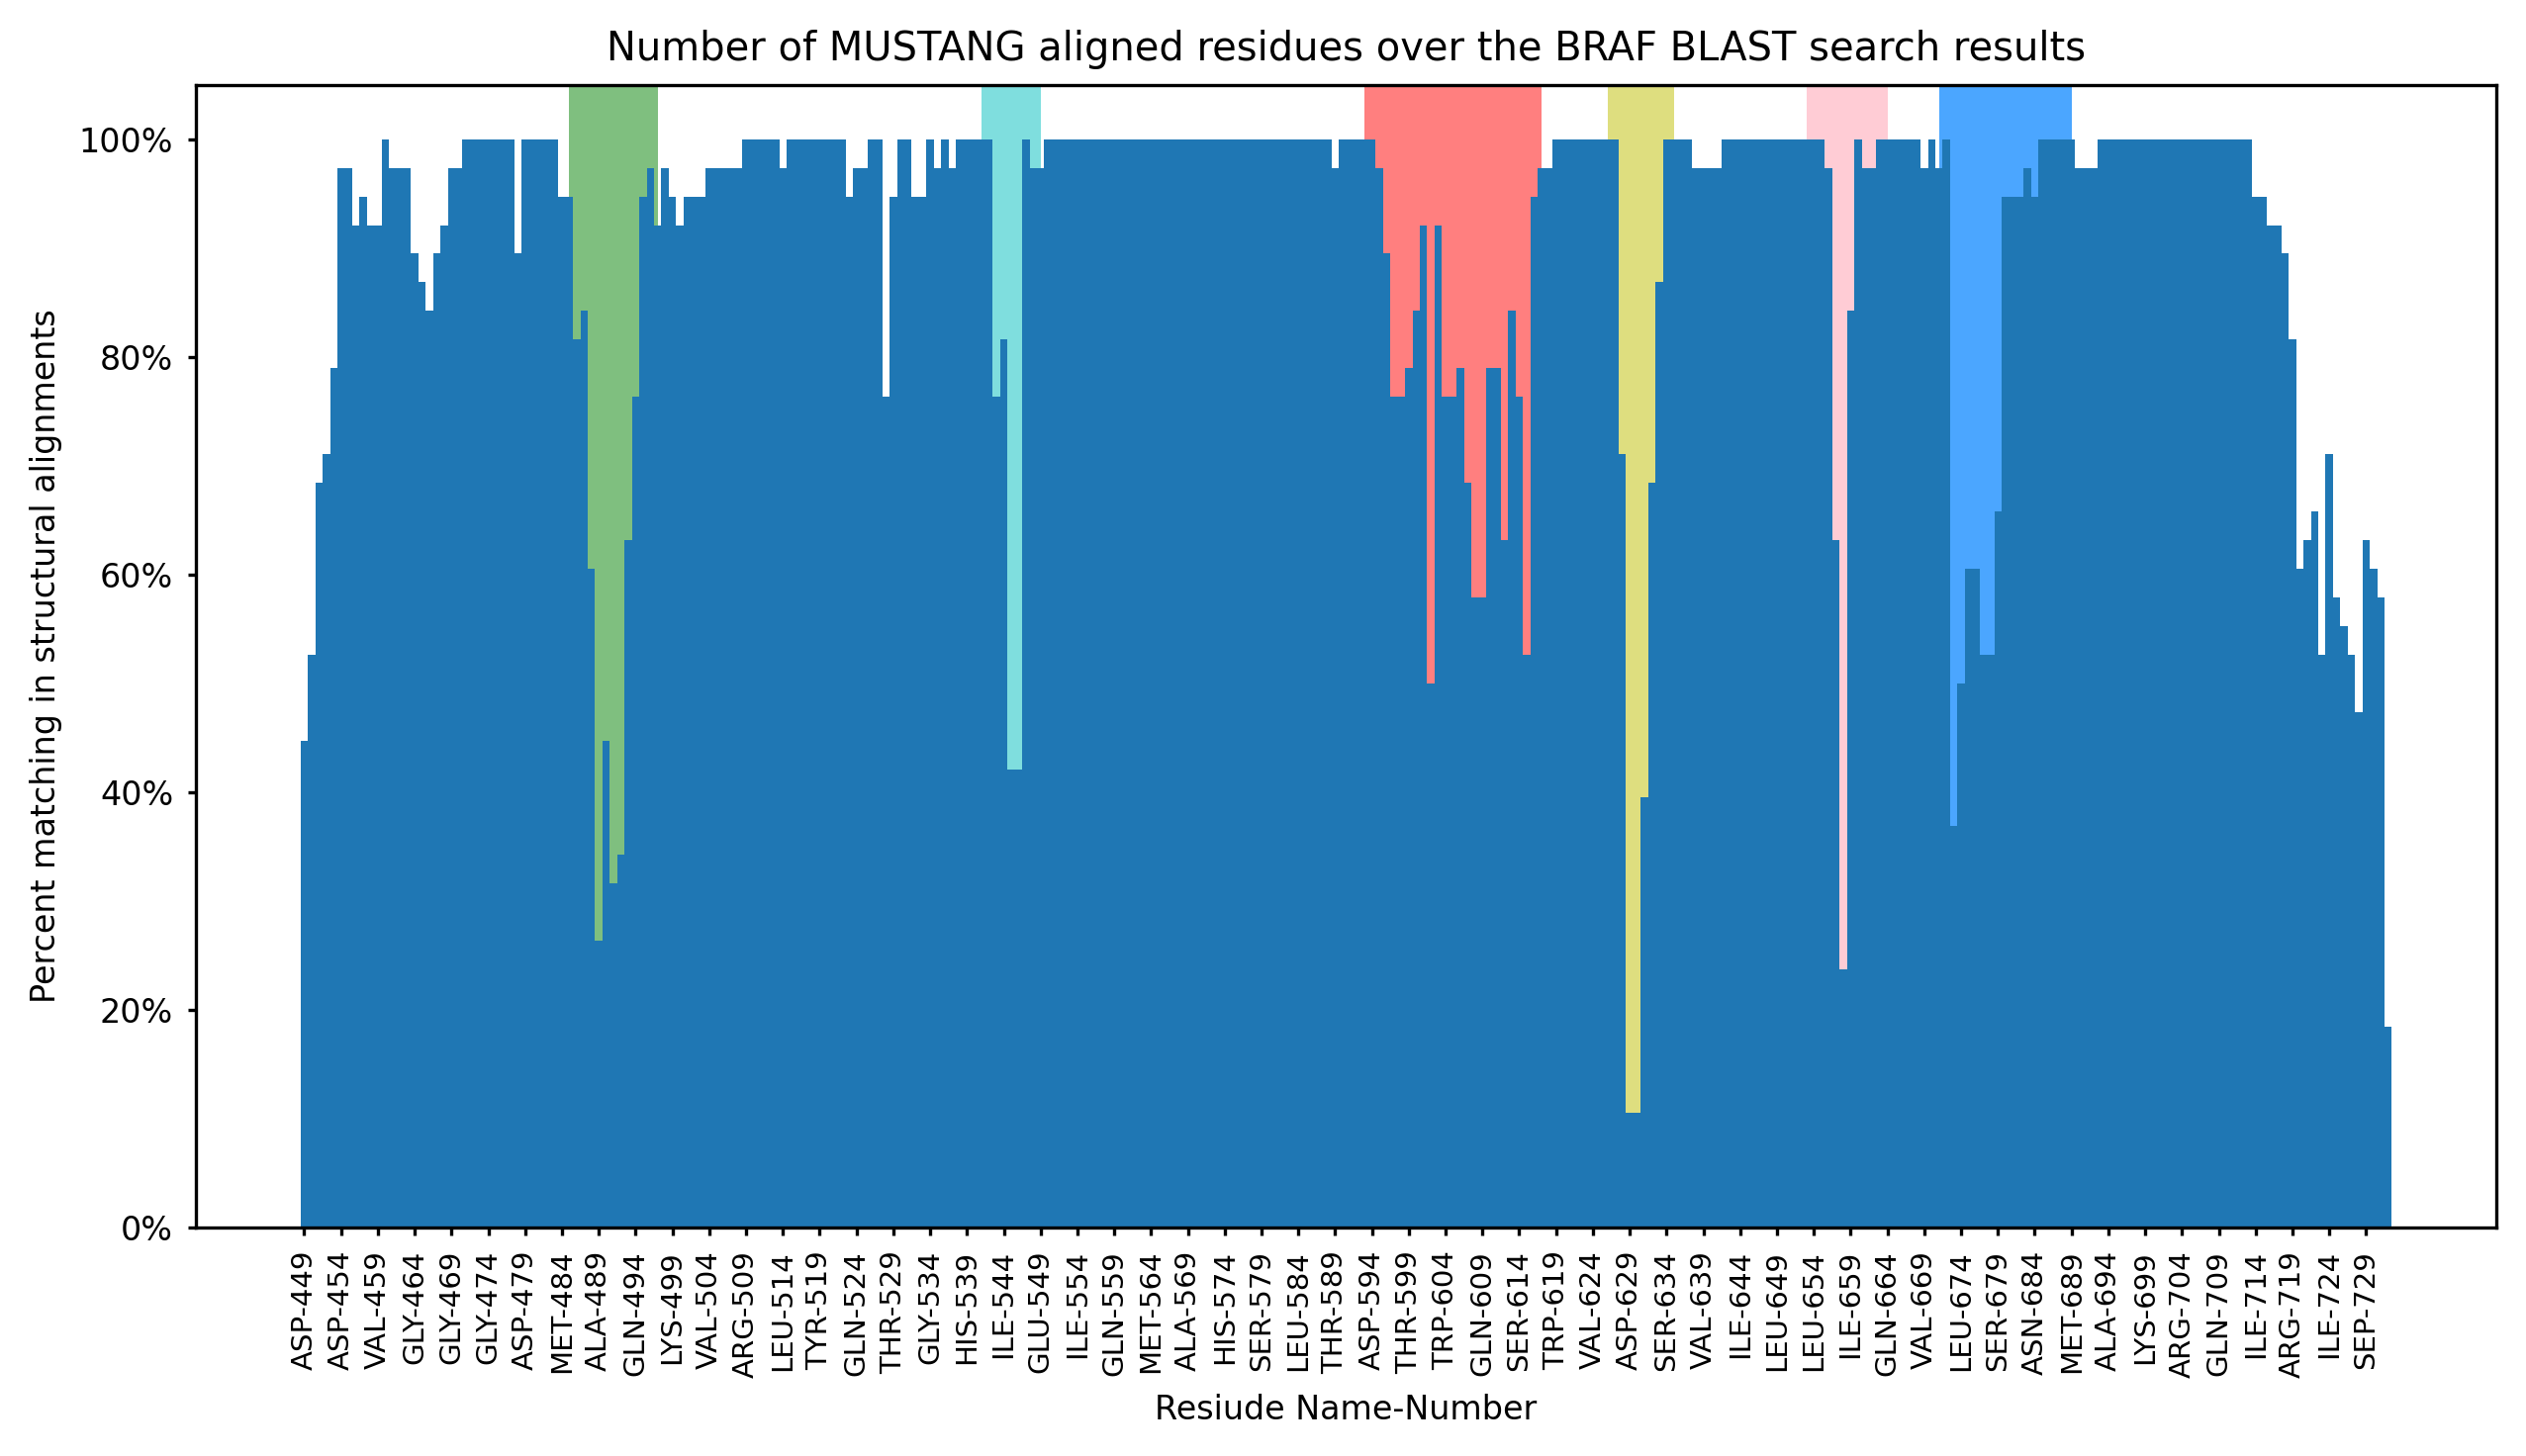

In [5]:
"""
Plotting the number of aligned residues over the BRAF BLAST search results to show what are the most conserved residues throughout the alignment
"""
from matplotlib.ticker import FuncFormatter
seq1mag = len(aligned[0].seq1.replace("-",""))
counts = np.zeros(seq1mag)
for a in aligned:
    segment = make_seg(a)
    for i,(b,c) in enumerate(segment):
        if c != "-":
            counts[i] += 1
counts =  counts / max(counts)
# sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(1,figsize=(10,5))
x = [*range(len(counts))]
ax.set_xticks(x[::5])
x_lbl = braf_res()
ax.set_xticklabels(x_lbl[::5],rotation=90,fontsize=7)
# subtract 11
ax.axvspan(36,48, facecolor='g', alpha=0.5)
ax.axvspan(92,100, facecolor='c', alpha=0.5)
ax.axvspan(144,168, facecolor='r', alpha=0.5)
ax.axvspan(177,186, facecolor='y', alpha=0.5)
ax.axvspan(204,215, facecolor='pink', alpha=0.8)
ax.axvspan(222,240, facecolor='dodgerblue', alpha=0.8)
ax.bar(x,counts,linewidth=0.05,width=1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
title = ax.set_title("Number of MUSTANG aligned residues over the BRAF BLAST search results")
ax1 = plt.xlabel("Resiude Name-Number")
ax1 = plt.ylabel("Percent matching in structural alignments")
ax.tick_params(length=2,color="black",direction="out")

In [6]:
"""
This cell finds PDBs with DFG and APE motifs aligned
"""
from collections import Counter
count = 0
new_aligned = []
bad = []
for k,a in enumerate(aligned):
    # If doesn't have anything matched totally to DFG and APE discard it
    if a.seq1.find("DFG") == -1 or a.seq1.find("APE") == -1:
        # print(a.name)
        bad.append(aligned)
        count += 1
    else:
        new_aligned.append(a)
print(count,"/",len(aligned), " don't match.")
print(f"Continuing with {len(new_aligned)} structures")

counts  = {}
counter = 0
new_aligned2 = []
aligning_segs = {}
lengths = []
for a in new_aligned:
    DFG_index = a.seq1.find("DFG")
    APE_index = a.seq1.find("APE")
    dfg = a.seq2[DFG_index]
    ape = a.seq2[APE_index]
    if dfg != "-" and ape != "-":
        counter+=1
        length = APE_index - DFG_index
        counts.setdefault(length,[]).append((a.name,DFG_index,APE_index))
        new_aligned2.append(a)
        aligning_segs.setdefault(a.name,
                                 (a.seq2[DFG_index:DFG_index+3],
                                  a.seq2[APE_index:APE_index+3],
                                  a.seq2[DFG_index:APE_index]))
        lengths.append(len(a.seq2[DFG_index:APE_index]))
    else:
        pass
        # print(a.name,dfg,ape)
print(f"{counter} structures with an alignment to the D and A")


1 / 38  don't match.
Continuing with 37 structures
37 structures with an alignment to the D and A


In [14]:
from glob import glob
import mdtraj as md

"""
Strips to CAs of activation segment
"""
def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path
def align_to_actv(pdb,
                  alignment,
                  align_distance=50):
    pdb = md.load(pdb)
    DFG_index = alignment.seq1.find("DFG")
    APE_index = alignment.seq1.find("APE") + 2 
    
    '''The following is to make sure that gaps are not counted in the index'''
    DFG_index = DFG_index - sum([1 for a in alignment.seq2[:DFG_index] if a == "-"])
    APE_index = APE_index - sum([1 for a in alignment.seq2[:APE_index] if a == "-"])
    
    actv_range = range(DFG_index, APE_index)
    
    
    atoms_indices = [[atom.index for atom in res.atoms if atom.name == "CA"] for res in pdb.top._residues if res.index in actv_range]
    atoms_indices = sum(atoms_indices, [])
    return pdb.atom_slice(atoms_indices)



In [15]:
'''The following block of code is the same as in the case of align_to_actv version with top_seq_matcher'''
names = []
rmsds = []
target_dir = f"Results/activation_segments/CA_segments/{kind}/"
ifnotmake(target_dir)
# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Get PDB names
pdb_dir = "Results/activation_segments/mustangs/"
fps = glob(pdb_dir+"/*/*.pdb")

# Process alignments
for align_obj in tqdm(new_aligned2):
    match_found = False
    for fp in fps:
        if align_obj.name in fp and "pdb" in fp:
            match_found = True
            break
    
    if not match_found:
        continue
    
    stripped = align_to_actv(fp, align_obj)
    
    '''
    #Not sure if this is necessary
    if stripped.n_residues > 35 or stripped.n_residues < 10:
        continue
    '''

    # Construct the file name and save the stripped pdb
    new_name = os.path.join(target_dir, align_obj.name + ".pdb")
    stripped.save(new_name)

  0%|          | 0/37 [00:00<?, ?it/s]

In [16]:
#Code to save only first and last residue in activation segment for further visualization (mainly to double check if mustang alignment makes sense or not)

import biobox as bb
import glob
import numpy as np

files = f"Results/activation_segments/CA_segments/{kind}/*.pdb"

start = []
end = []
for f in glob.glob(files):

    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")

    start.append(pts[0])
    end.append(pts[-1])

#start = np.array(start)
#end = np.array(end)

M_start = bb.Structure(p=np.array(start))
M_end = bb.Structure(p=np.array(end))

M_start.write_pdb("start_CA.pdb")
M_end.write_pdb("end_CA.pdb")

In [ ]:
#this is right and it works, but renumbers residues meaning that the ones that are missing are ignored

from Bio import PDB
import numpy as np
from scipy.interpolate import interp1d
import os
import tempfile
import mdtraj as md
from scipy.interpolate import make_interp_spline
def fitting_code(fp_or_traj, save_path):
    # Function to read PDB file or trajectory object and get model
    def read_structure(input_data):
        if isinstance(input_data, str):
            # If input is a string, treat it as a file path
            parser = PDB.PDBParser(QUIET=True)
            structure = parser.get_structure('structure', input_data)
        elif isinstance(input_data, md.Trajectory):
            # If input is a trajectory, save to temp PDB and read
            with tempfile.NamedTemporaryFile(suffix=".pdb", delete=False) as tmpfile:
                input_data.save(tmpfile.name)
                tmpfile.close()
                parser = PDB.PDBParser(QUIET=True)
                structure = parser.get_structure('structure', tmpfile.name)
            os.unlink(tmpfile.name)
        else:
            raise ValueError("Unsupported input type. Provide a file path or md.Trajectory.")
        return structure[0]

    # Read the template for CA atoms configuration
    template_model = read_structure('template.pdb')
    Nnew = len([atom for atom in template_model.get_atoms() if atom.get_id() == 'CA'])

    # Read input PDB file or trajectory
    my_model = read_structure(fp_or_traj)
    atom_list = [atom for atom in my_model.get_atoms() if atom.get_id() == 'CA']
    #print(f'shape atom list in input{np.shape(atom_list)}')

    n = len(atom_list)
    avg = np.array([[atom.coord[0], atom.coord[1], atom.coord[2]] for atom in atom_list])
    #print(f'shape atom coordinates in input{np.shape(avg)}')

    
    dims = ['x', 'y', 'z']
    fits = {}
    #splines = {}
    # Fit cubic interpolation for each axis
    for j, dim in enumerate(dims):
        #splines[dim] = make_interp_spline(np.arange(n), avg[:, j], k=3)  # 'k=3' for cubic spline 
        fits[dim] = interp1d(np.arange(n), avg[:, j], kind='cubic', fill_value='extrapolate')
    print(avg)
    #print(f'fits{fits}')
    # Interpolation scales
    X = np.arange(0, n-1, 0.1)
    #X = np.arange(0, n - 0.2, 0.1)

    # Get derivative
    dYdX = {dim: np.gradient(fits[dim](X)) for dim in dims}
    #evaluated_splines = {dim: np.gradient(splines[dim](X)) for dim in dims}
    #print(f'derivative{dYdX}')
    # Calculate path length
    Y = np.sqrt(sum(np.square(dYdX[dim]) for dim in dims))
    #Y = np.sqrt(sum(np.square(evaluated_splines[dim]) for dim in dims))
    L = np.trapz(Y, X)

    # Create an interpolated arc length
    Li = np.linspace(0, L, Nnew)
    
    # Calculate the arc length for each sampled point
    flen = np.array([np.trapz(Y[:ibig], X[:ibig]) for ibig in range(1, len(X))])

    pt = np.zeros(Nnew, dtype=int)
    for i in range(Nnew):
        pt[i] = np.argmin(np.abs(flen - Li[i]))

    new_coords = np.array([[fits[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])
    #new_coords = np.array([[splines[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])
    ca_index = 0
    for atom in template_model.get_atoms():
            if atom.get_id() == 'CA':
                atom.set_coord(new_coords[ca_index])
                ca_index += 1
        
        # Now let's write the updated PDB to the file
    try:
        with open(save_path, "w") as file:
            io = PDB.PDBIO()
            io.set_structure(template_model)
            io.save(file)
        print(f'Successfully saved the structure to {save_path}')
    except Exception as e:
        print(f"Error during file save: {e}")
    pt = np.zeros(Nnew, dtype=int)
    for i in range(Nnew):
        pt[i] = np.argmin(np.abs(flen - Li[i]))

    new_coords = np.array([[fits[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])
    #new_coords = np.array([[splines[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])
    ca_index = 0
    for atom in template_model.get_atoms():
            if atom.get_id() == 'CA':
                atom.set_coord(new_coords[ca_index])
                ca_index += 1
        
        # Now let's write the updated PDB to the file
    try:
        with open(save_path, "w") as file:
            io = PDB.PDBIO()
            io.set_structure(template_model)
            io.save(file)
        print(f'Successfully saved the structure to {save_path}')
    except Exception as e:
        print(f"Error during file save: {e}")


In [ ]:
from glob import glob
import os
# Start MATLAB
#import matlab.engine
from tqdm.notebook import tqdm
TARGET_DIR = "Results/fitted_matlab_segments/mustang"
os.makedirs(TARGET_DIR, exist_ok=True)
def pdb_id(fp):
    return fp.rsplit(".",1)[0].rsplit("/",1)[1]


In [ ]:
PDB_PATH = "Results/activation_segments/CA_segments/mustang/"
#xyz = md.load("/home/marmatt/Documents/projects/BRAF/results/activation_segments/CA_segments/mustang/1A9U_A.pdb")
files = glob(PDB_PATH+"/*.pdb")
ids = [pdb_id(f) for f in files]
print(ids)
out = [TARGET_DIR + f"/{i}.pdb" for i in ids]
#print(files[0],ids[0],out[0])

for f, n in tqdm(zip(files,out),total=len(files)):
    fitting_code(f,n)

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md


# Usage Example
xyz = md.load("Results/activation_segments/CA_segments/mustang/1AD5_A.pdb")

DFG = xyz.top.to_fasta()[0].find("DFG")
APE = xyz.top.to_fasta()[0].find("APE")+2
atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in xyz.top._residues[:]],[])

coords = xyz.xyz[0,atoms].T
x = coords[0]
y = coords[1]
z = coords[2]
new_coords = md.load("Results/fitted_matlab_segments/mustang/1AD5_A.pdb")

atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in new_coords.top._residues[:]],[])
new_coords = new_coords.xyz[0,atoms].T
xp = new_coords[0]
yp = new_coords[1]
zp = new_coords[2]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z, 'blue',marker="o")
ax.plot3D(xp, yp, zp, 'red')
plt.tick_params(bottom=False, top=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])